# $$Otimização~de~Hiperparâmetros$$

### $$Conceito:$$


Os hiperparâmetros são parâmetros ajustáveis que permitem controlar o processo de treinamento do modelo, o ajuste de hiperparâmetros, também chamado de otimização de hiperparâmetros, é o processo de localizar a configuração de hiperparâmetros que resulta no melhor desempenho. O processo normalmente é manual e caro em termos computacionais


### $$Parâmetros~VS~Hiperparâmetros:$$


#### **Parâmetros:**

Os **Parâmetro** são ajustados diretamente pelo processo de aprendizado e influenciam diretamente na performance do algoritmo. Os coeficientes de uma regressão linear, os pesos de uma rede neural, as fronteiras das vizinhanças no kNN, todos esses são parâmetros que **se ajustam ao treinar o modelo preditivo** para um conjunto de dados.

#### **Hiperparâmetros:**


Os **Hiperparâmetros** são variáveis do algoritmo **definidas antes do treinamento**. Eles representam características mais construtivas, como a métrica de performance de uma regressão (MSE, R²,…), o número de neurônios de uma rede neural (ou camadas), o número de vizinhos do kNN. Os hiperparâmetros são muito importantes para a performance do modelo preditivo e caso escolhidos de qualquer jeito, podem torná-lo inútil, ou muito longe do ótimo


### $$Algoritmos~de~ajustes~de~Hiperparâmetros:$$


#### **Grid Search:** 

Algoritmo procura o conjunto que leva ao melhor score testando todas as possibilidade do grid, ele é computacionalmente o método mais demorado e nem sempre obtém os melhores resultados.

#### **Randomized Search:** 

Em contraste com o GridSearchCV, nem todos os valores dos parâmetros são testados, mas sim um número fixo de configurações de parâmetros é amostrado a partir das distribuições especificadas.

#### **Bayesian Optimization:**

A Otimização Bayesiana “aprende” com cada teste feito, o resultado de um modelo ajuda a criar o próximo modelo




__------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__


__------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__

## $$Objetivo:$$

## $$Encontrar~ os~ melhores~ hiperparâmetros~ de~ cada~ modelo$$$$utilizando~ os~ algoritmos~ de~ otimização$$



__------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__


__------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__

In [1]:
#Pacote
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from time import time

# Banco de dados 

In [2]:
#Carregar dataset
dados = pd.read_csv('credit.csv',encoding='latin1',sep=',')
dados

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


**São 32.581 linhas e 12 variáveis**

Fonte: https://www.kaggle.com/laotse/credit-risk-dataset

# Análise Exploratória

In [3]:
#Tipos de variáveis
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


**Temos 4 variáveis categóricas e 8 numéricas**

**OBS: A maioria dos algoritmos de Machine Learning não conseguem lidar com variáveis categóricas, então precisamos transforma-las em números (Dummies)**


In [4]:
#Transformar as variáveis object em numericas

#Aplicar transformação nos dados
dummies =  pd.get_dummies(dados[['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file']])

#Excluir as variáveis object
dados = dados.drop(['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file'],axis=1)

#Juntar as variáveis dummies com dataset 
dados_transform = dados.join(dummies)

#Dataset
dados_transform.head(5)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,22,59000,123.0,35000,16.02,1,0.59,3,0,0,...,0,0,0,0,1,0,0,0,0,1
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1


**Variáveis dummies adicionadas no dataset**

In [5]:
#Tipos de variáveis
dados_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      32581 non-null  int64  
 1   person_income                   32581 non-null  int64  
 2   person_emp_length               31686 non-null  float64
 3   loan_amnt                       32581 non-null  int64  
 4   loan_int_rate                   29465 non-null  float64
 5   loan_status                     32581 non-null  int64  
 6   loan_percent_income             32581 non-null  float64
 7   cb_person_cred_hist_length      32581 non-null  int64  
 8   person_home_ownership_MORTGAGE  32581 non-null  uint8  
 9   person_home_ownership_OTHER     32581 non-null  uint8  
 10  person_home_ownership_OWN       32581 non-null  uint8  
 11  person_home_ownership_RENT      32581 non-null  uint8  
 12  loan_intent_DEBTCONSOLIDATION   

**Agora todas as variaveis são numericas**

In [6]:
#Verificar dados NAN
nan = dados_transform.isnull().values.sum()
print(f'Dados NaN = {nan}')

#Remover dados NaN
dados_transform1 = pd.DataFrame(dados_transform.dropna(axis=0, how='any'))
print(f'Dados NaN após transformação = {dados_transform1.isnull().values.sum()}')
print(f'Tamanho do dataset após transformação = {dados_transform1.shape}')

Dados NaN = 4011
Dados NaN após transformação = 0
Tamanho do dataset após transformação = (28638, 27)


**Dataset sem registros nulos**

# Modelagem: 

- Para cada algoritmo aplicaremos os 3 ajustes de hiperparâmetros 


- Objetivo: Comparar o tempo de execução e o resultado final de cada modelo

# Algoritmo - DecisionTreeClassifier:

- Árvore de decisão usando criterio gini

## Sem Otimização de hiperparâmetros

In [7]:
#Divisão dos dados em X e Y
x = dados_transform1.drop('loan_status',axis=1)
y = dados_transform1.loan_status

#Divisão entre treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1)

In [8]:
start = time()

# Construção do Classificador
decision_tree = DecisionTreeClassifier(random_state = 1)

#Treinar o modelo com os dados de treino
decision_tree.fit(X_train, y_train)

# Score do modelo
scores = cross_val_score(decision_tree, X_train, y_train)

#Score do modelo com os dados de teste
decision_tree_score = decision_tree.score(X_test,y_test)
print(f'\nScore Teste: {round(decision_tree_score,3)*100}%')

#Tempo de execução do modelo
time1 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))


Score Teste: 89.1%

Execução em 0.54 segundos.


**Resultado do modelo DecisionTreeClassifier sem otimização**

## Randomized Search

In [9]:
#Pacote RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [10]:
start = time()
import warnings
warnings.filterwarnings('ignore')

# Definição dos parâmetros
param_dist = {"max_depth": [0,1,2,4,5,7,8,10,20],"min_samples_split": [0,1,2,4,5,7,8,10,20],
              "min_samples_leaf": [0,1,2,4,5,7,8,10,20],"criterion":['gini','entropy'],
               "max_features": [0,1,2,4,5,7,8,10,20]}

# Construção do Classificador
TreeClas_model = DecisionTreeClassifier(random_state = 1)

# Usar o modelo DecisionTreeClassifier para otimização dos hiperparametros
TreeClas_rsearch = RandomizedSearchCV(TreeClas_model,param_distributions = param_dist,n_iter=300, random_state = 1)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
TreeClas_rsearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = TreeClas_rsearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
TreeClas_rsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(TreeClas_rsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time2 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

DecisionTreeClassifier(max_depth=10, max_features=20, min_samples_leaf=5,
                       min_samples_split=7, random_state=1)


Acurácia: 93.0%

Execução em 19.72 segundos.


**Resultado do modelo usando Randomized Search**

##  Grid Search

In [11]:
#Pacote GridSearchCV
from sklearn.model_selection import GridSearchCV

In [12]:
start = time()

# Definição dos parâmetros
param_dist = {"max_depth": [0,2,5,8,10],
              "min_samples_split": [0,2,5,8,10],
              "min_samples_leaf": [0,2,5,8,10],
              "criterion":['gini','entropy'],
               "max_features": [0,2,5,8,10]}

# Construção do Classificador
TreeClas_model = DecisionTreeClassifier(random_state = 1)


# Usar o modelo DecisionTreeClassifier para otimização dos hiperparametros
TreeClas_gsearch = GridSearchCV(TreeClas_model,param_grid = param_dist)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
TreeClas_gsearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = TreeClas_gsearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
TreeClas_gsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(TreeClas_gsearch_acuracy,3)*100}%')

#Tempo de execução do modelo

#Tempo de execução do modelo
time3 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=10,
                       min_samples_leaf=2, min_samples_split=8, random_state=1)


Acurácia: 91.4%

Execução em 67.50 segundos.


**Resultado do modelo usando Grid Search**

##  BayesSearchCV

In [13]:
#Pacote BayesSearchCV
from skopt import BayesSearchCV


In [14]:
import warnings
warnings.filterwarnings('ignore')
start = time()

# Definição dos parâmetros
param_dist = {"max_depth": [1,2,4,5,7,8,10,20],"min_samples_split": [2,4,5,7,8,10,20],
              "min_samples_leaf": [1,2,4,5,7,8,10,20],"criterion":['gini','entropy'],
               "max_features": [1,2,3,4,8,10,11]}


# Construção do Classificador
TreeClas_model = DecisionTreeClassifier(random_state = 1)

# Usar o modelo DecisionTreeClassifier para otimização dos hiperparametros
TreeClas_BayesSearchCV = BayesSearchCV(TreeClas_model,param_dist)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
TreeClas_BayesSearchCV.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = TreeClas_BayesSearchCV.best_estimator_
print (f'              **Melhores parametros com BayesSearchCV**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)


# Acurácia
TreeClas_BayesSearchCV_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(TreeClas_BayesSearchCV_acuracy,2)*100}%')

#Tempo de execução do modelo
time4 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com BayesSearchCV**

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=10,
                       min_samples_split=4, random_state=1)


Acurácia: 92.0%

Execução em 74.66 segundos.


**Resultado do modelo usando BayesSearchCV**

## Comparando os 4 modelos 

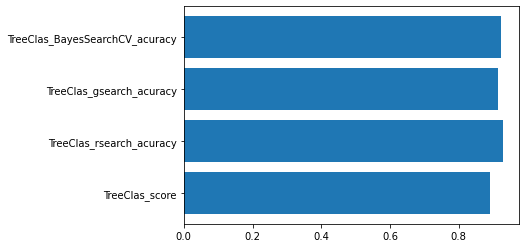

In [15]:
import matplotlib.pyplot as plt
scores = pd.DataFrame([decision_tree_score,TreeClas_rsearch_acuracy,
                       TreeClas_gsearch_acuracy,TreeClas_BayesSearchCV_acuracy])

scores['columns1'] =  ['TreeClas_score','TreeClas_rsearch_acuracy',
                       'TreeClas_gsearch_acuracy','TreeClas_BayesSearchCV_acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores']);


In [16]:
#Valor dos Scores dos modelos 
scores['Time(Seg)'] = time1,time2,time3,time4
dts = scores
dts

,Scores,Modelos,Time(Seg)
0,0.891061,TreeClas_score,0.538
1,0.927607,TreeClas_rsearch_acuracy,19.719
2,0.914455,TreeClas_gsearch_acuracy,67.500
3,0.922370,TreeClas_BayesSearchCV_acuracy,74.656


**Observamos que os modelos com otimização foram os que tiveram os melhores desempenhos, porém com maior poder computacional**

## Algoritmo - Extremely Randomized Trees (ExtraTrees)

- **São criadas várias arvores com dados aleatórios, os dados existentes em cada uma destas variáveis serão separados também de maneira aleatória, para que o nó raiz varie em algumas árvores**

## Sem Otimização de hiperparâmetros

In [17]:
#Pacote ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [18]:
start = time()

# Construção do Classificador
ExtraTrees = ExtraTreesClassifier(min_samples_split = 2, random_state = 1)

#Treinar o modelo com os dados de treino
ExtraTrees.fit(X_train, y_train)

#Score do modelo com os dados de teste
ExtraTrees_score = ExtraTrees.score(X_test,y_test)
print(f'\nScore Teste: {round(ExtraTrees_score,2)*100}%')

#Tempo de execução do modelo
time1 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))


Score Teste: 92.0%

Execução em 1.59 segundos.


**Resultado do modelo sem otimização**

## Randomized Search

In [19]:
start = time()

# Definição dos parâmetros

param_dist = {"max_depth": [1, 3, 7, 8],
              "max_features": [2,4,5,7,8],
              "min_samples_split": [3,4,5,7,10],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7],
              "bootstrap": [True, False],
              "criterion": ['gini','entropy']}


# Construção do Classificador
ExtraTrees = ExtraTreesClassifier(random_state = 1)


# Usar o modelo ExtraTreesClassifier para otimização dos hiperparametros
ExtraTrees_rsearch = RandomizedSearchCV(ExtraTrees,param_distributions = param_dist,n_iter=100,random_state = 1)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
ExtraTrees_rsearch.fit(X_train, y_train)


# Imprimindo o melhor estimador
bestclf = ExtraTrees_rsearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
ExtraTrees_rsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(ExtraTrees_rsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time2 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

ExtraTreesClassifier(max_depth=8, max_features=8, min_samples_leaf=4,
                     min_samples_split=10, random_state=1)


Acurácia: 89.0%

Execução em 196.53 segundos.


**Resultado do modelo usando Randomized Search**

##  Grid Search

In [20]:
start = time()
# Definição dos parâmetros

param_dist = {"max_depth": [ 7, 8],
              "max_features": [8,10],
              "min_samples_split": [7,10],
              "min_samples_leaf": [8,10],
              "bootstrap": [True, False],
              "criterion": ['gini']}


# Construção do Classificador
ExtraTrees = ExtraTreesClassifier(random_state = 1)


# Usar o modelo ExtraTreesClassifier para otimização dos hiperparametros
ExtraTrees_gsearch = GridSearchCV(ExtraTrees,param_grid = param_dist)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
ExtraTrees_gsearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = ExtraTrees_gsearch.best_estimator_
print (f'              **Melhores parametros com Grid Search**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
ExtraTrees_gsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(ExtraTrees_gsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time3 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com Grid Search**

ExtraTreesClassifier(max_depth=8, max_features=10, min_samples_leaf=8,
                     min_samples_split=7, random_state=1)


Acurácia: 90.0%

Execução em 104.25 segundos.


**Resultado do modelo usando Grid Search**

##  BayesSearchCV

In [21]:
import warnings
warnings.filterwarnings('ignore')
start = time()
# Definição dos parâmetros

param_dist = {"max_depth": [1, 3, 7, 8],
              "max_features": [2,4,5,7,8],
              "min_samples_split": [3,4,5,7,10],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7],
              "bootstrap": [True, False],
              "criterion": ['gini','entropy']}


# Construção do Classificador
ExtraTrees_mpdel = ExtraTreesClassifier(random_state = 1)


# Usar o modelo Bagging para otimização dos hiperparametros
ExtraTrees_BayesSearch = BayesSearchCV(ExtraTrees_mpdel,param_dist)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
ExtraTrees_BayesSearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = ExtraTrees_BayesSearch.best_estimator_
print (f'              **Melhores parametros com BayesSearchCV**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
ExtraTrees_BayesSearch_acuracy = accuracy_score(y_test, y_pred)

print(ExtraTrees_BayesSearch_acuracy)

#Tempo de execução do modelo
time4 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com BayesSearchCV**

ExtraTreesClassifier(criterion='entropy', max_depth=8, max_features=8,
                     min_samples_leaf=6, min_samples_split=7, random_state=1)

0.8873370577281192

Execução em 222.38 segundos.


**Resultado do modelo usando BayesSearchCV**

## Comparando os 4 modelos com ExtraTrees

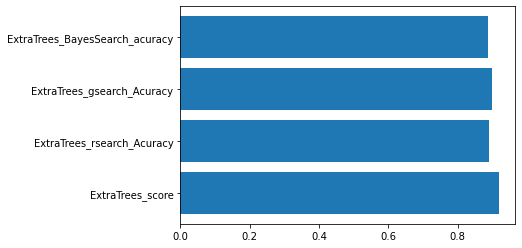

In [22]:
#Modelos
scores = pd.DataFrame([ExtraTrees_score,ExtraTrees_rsearch_acuracy,
                       ExtraTrees_gsearch_acuracy,ExtraTrees_BayesSearch_acuracy])

scores['columns1'] =  ['ExtraTrees_score','ExtraTrees_rsearch_Acuracy',
                       'ExtraTrees_gsearch_Acuracy','ExtraTrees_BayesSearch_acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores']);

In [23]:
#Valor dos Scores dos modelos 
scores['Time(Seg)'] = time1,time2,time3,time4
ert = scores
ert

,Scores,Modelos,Time(Seg)
0,0.920507,ExtraTrees_score,1.594
1,0.891061,ExtraTrees_rsearch_Acuracy,196.525
2,0.899907,ExtraTrees_gsearch_Acuracy,104.253
3,0.887337,ExtraTrees_BayesSearch_acuracy,222.382


**O Modelo ExtraTrees com BayesSearch é o algoritmo que requer maior poder computacional, porém o modelo sem otimização obteve o melhor resultados com poucos segundos de treinamento**

## Algoritmo - Adaboost

 - **O Adaboost consegue melhorar um novo preditor ao prestar atenção às instâncias em que o seu antecessor realizou. Isso resulta em novos preditores capazes de cobrir pelos erros passados**

## Sem Otimização de hiperparâmetros

In [24]:
#Pacote AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

In [71]:
start = time()

# Construção do Classificador
AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), 
                                learning_rate = 0.1, 
                                n_estimators = 400, 
                                algorithm = "SAMME",
                                random_state=1)

#Treinar o modelo com os dados de treino
AdaBoost.fit(X_train, y_train)

#Score do modelo com os dados de teste
AdaBoost_score= AdaBoost.score(X_test,y_test)
print(f'\nScore Teste: {round(AdaBoost_score,2)*100}%')

#Tempo de execução do modelo
time1 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))


Score Teste: 89.0%

Execução em 0.15 segundos.


**Resultado do modelo sem otimização**

## Randomized Search

In [26]:
start = time()

# Definição dos parâmetros

param_dist = {"learning_rate": [0.0000000001,0.0001,0.01,0.1,1.0,3.0],
              "n_estimators": [50,100,200,4000],
              "algorithm": ['SAMME', 'SAMME.R'],
              "n_estimators": [100] }

# Construção do Classificador
AdaBoost = AdaBoostClassifier(random_state=1)
    

# Usar o modelo Adaboost para otimização dos hiperparametros
Adaboost_rsearch = RandomizedSearchCV(AdaBoost,param_distributions = param_dist,n_iter=10, random_state = 1)


# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
Adaboost_rsearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = Adaboost_rsearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
Adaboost_rsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(Adaboost_rsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time2 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

AdaBoostClassifier(n_estimators=100, random_state=1)


Acurácia: 89.0%

Execução em 58.04 segundos.


**Resultado do modelo usando Randomized Search**

## Grid Search

In [27]:
start = time()

# Definição dos parâmetros
param_dist = {"learning_rate": [0.0001,0.01,0.1,1.0,3.0],
              "n_estimators": [100],
              "algorithm": ['SAMME', 'SAMME.R']}

# Construção do Classificador
AdaBoost = AdaBoostClassifier(random_state=1)

# Usar o modelo Bagging para otimização dos hiperparametros
Adaboost_gsearch = GridSearchCV(AdaBoost,param_grid = param_dist)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
Adaboost_gsearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = Adaboost_gsearch.best_estimator_
print (f'              **Melhores parametros com Grid Search**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
Adaboost_gsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(Adaboost_gsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time3 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com Grid Search**

AdaBoostClassifier(n_estimators=100, random_state=1)


Acurácia: 89.0%

Execução em 50.73 segundos.


**Resultado do modelo usando Grid Search**

## BayesSearchCV

In [28]:
import warnings
warnings.filterwarnings('ignore')
start = time()

# Definição dos parâmetros

param_dist = {"learning_rate": [0.0001,0.01,0.1,1.0],
              "n_estimators": [40],
              "algorithm": ['SAMME', 'SAMME.R']}

# Construção do Classificador
AdaBoost = AdaBoostClassifier(random_state=1)

# Usar o modelo Bagging para otimização dos hiperparametros
AdaBoost_BayesSearch = BayesSearchCV(AdaBoost,param_dist)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
AdaBoost_BayesSearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = AdaBoost_BayesSearch.best_estimator_
print (f'              **Melhores parametros com BayesSearchCV**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
AdaBoost_BayesSearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(AdaBoost_BayesSearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time4 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com BayesSearchCV**

AdaBoostClassifier(n_estimators=40, random_state=1)


Acurácia: 88.0%

Execução em 166.48 segundos.


**Resultado do modelo usando BayesSearchCV**

## Comparando os 4 modelos com AdaBoost

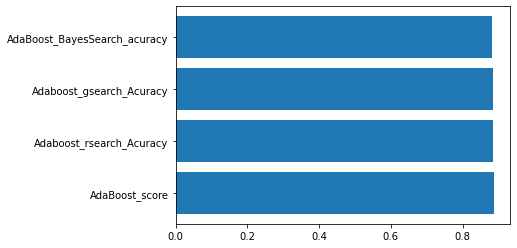

In [29]:
## Comparando os 3 modelos com ExtraTrees#Modelos
scores = pd.DataFrame([AdaBoost_score,Adaboost_rsearch_acuracy,
                       Adaboost_gsearch_acuracy,AdaBoost_BayesSearch_acuracy])

scores['columns1'] =  ['AdaBoost_score','Adaboost_rsearch_Acuracy',
                       'Adaboost_gsearch_Acuracy','AdaBoost_BayesSearch_acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores']);

In [30]:
#Valor dos Scores dos modelos 
scores['Time(Seg)'] = time1,time2,time3,time4
adb = scores
adb

,Scores,Modelos,Time(Seg)
0,0.888734,AdaBoost_score,0.120
1,0.886057,Adaboost_rsearch_Acuracy,58.040
2,0.886057,Adaboost_gsearch_Acuracy,50.729
3,0.880819,AdaBoost_BayesSearch_acuracy,166.477


**Não há diferença em nenhum dos modelos, nenhum deles conseguiu ter uma boa performance**

## Algoritmo - Gradient Boosting

- **Cada nova árvore é um ajuste em uma versão modificada do conjunto de dados original. O objetivo do algoritmo é criar uma corrente de modelos fracos, onde cada um tem como objetivo minimizar o erro do modelo anterior, por meio de uma função de perda**

## Sem Otimização de hiperparâmetros

In [31]:
#Pacote GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [32]:
start = time()

# Construção do Classificador
GradientBoosting = GradientBoostingClassifier(min_samples_split = 2, random_state = 1)

#Treinar o modelo com os dados de treino
GradientBoosting.fit(X_train, y_train)

#Score do modelo com os dados de teste
GradientBoosting_score= GradientBoosting.score(X_test,y_test)
print(f'\nScore Teste: {round(GradientBoosting_score,2)*100}%')

#Tempo de execução do modelo
time1 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))


Score Teste: 93.0%

Execução em 2.33 segundos.


**Resultado do modelo sem otimização**

## Randomized Search

In [33]:
start = time()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Definição dos parâmetros

param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 6,8],
              'min_samples_leaf': [3, 5],
              'subsample': [0.3, 0.5, 0.7],
              'n_estimators': [60],
              'loss': ['deviance', 'exponential'],
              'criterion' : [ 'squared_error', 'mse']}

# Construção do Classificador
GradientBoosting = GradientBoostingClassifier()


# Modelo criado com GridSearchCV
GradientBoosting_rsearch = RandomizedSearchCV(GradientBoosting, param_grid).fit(X_train, y_train)


# Imprimindo o melhor estimador
bestclf = GradientBoosting_rsearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
GradientBoosting_rsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(GradientBoosting_rsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time2 = round((time() - start),3)
print("\nExecução em %.2f segunds." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                           max_depth=6, min_samples_leaf=5, n_estimators=60,
                           subsample=0.7)


Acurácia: 93.0%

Execução em 51.90 segunds.


**Resultado do modelo usando Randomized Search**

## GridSearchCV

In [34]:
start = time()
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Grid de parâmetros
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 6,8],
              'min_samples_leaf': [3, 5],
              'subsample': [0.3, 0.5, 0.7],
              'n_estimators': [40]
              }

# Classifier
GradientBoosting_grid = GradientBoostingClassifier()

# Modelo criado com GridSearchCV
GradientBoosting_grid = GridSearchCV(GradientBoosting_grid, param_grid).fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = GradientBoosting_grid.best_estimator_
print (f'              **Melhores parametros com GridSearchCV**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
GradientBoosting_grid_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(GradientBoosting_grid_acuracy,2)*100}%')

#Tempo de execução do modelo
time3 = round((time() - start),3)
print("\nExecução em %.2f segunds." 
      % ((time() - start)))

              **Melhores parametros com GridSearchCV**

GradientBoostingClassifier(max_depth=6, min_samples_leaf=5, n_estimators=40,
                           subsample=0.5)


Acurácia: 93.0%

Execução em 227.34 segunds.


**Resultado do modelo usando GridSearchCV**

## BayesSearchCV

In [35]:
import warnings
warnings.filterwarnings('ignore')
start = time()
# Definição dos parâmetros

# Grid de parâmetros
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 6,8],
              'min_samples_leaf': [3, 5],
              'subsample': [0.3, 0.5, 0.7],
              'n_estimators': [40]
              }


# Classifier
GradientBoosting_BayesSearch = GradientBoostingClassifier()

# Usar o modelo Bagging para otimização dos hiperparametros
GradientBoosting_BayesSearch = BayesSearchCV(GradientBoosting_BayesSearch,param_grid)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
GradientBoosting_BayesSearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = GradientBoosting_BayesSearch.best_estimator_
print (f'              **Melhores parametros com BayesSearchCV**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
GradientBoosting_BayesSearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(GradientBoosting_BayesSearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time4 = round((time() - start),3)
print("\nExecução em %.2f segunds." 
      % ((time() - start)))

              **Melhores parametros com BayesSearchCV**

GradientBoostingClassifier(max_depth=6, min_samples_leaf=5, n_estimators=40,
                           subsample=0.7)


Acurácia: 93.0%

Execução em 339.22 segunds.


**Resultado do modelo usando BayesSearchCV**

## Comparando os 4 modelos com GradientBoosting

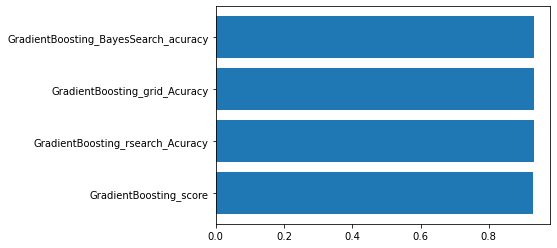

In [36]:
## Comparando os 3 modelos 
scores = pd.DataFrame([GradientBoosting_score,GradientBoosting_rsearch_acuracy,
                       GradientBoosting_grid_acuracy,GradientBoosting_BayesSearch_acuracy])

scores['columns1'] =  ['GradientBoosting_score','GradientBoosting_rsearch_Acuracy',
                       'GradientBoosting_grid_Acuracy','GradientBoosting_BayesSearch_acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores']);

In [37]:
#Valor dos Scores dos modelos 
scores['Time(Seg)'] = time1,time2,time3,time4
gb = scores
gb

,Scores,Modelos,Time(Seg)
0,0.929818,GradientBoosting_score,2.334
1,0.933426,GradientBoosting_rsearch_Acuracy,51.898
2,0.932961,GradientBoosting_grid_Acuracy,227.343
3,0.933194,GradientBoosting_BayesSearch_acuracy,339.218


**Todos os modelos tiveram uma boa performance**

## Algoritmo - XGBClassifier

- **É uma melhora do Gradient Boosting pois possui mais parâmetros e é otimizada tanto para eficiência de memória quanto para velocidade de treinamento**

## Sem Otimização de hiperparâmetros

In [38]:
#Pacote XGBClassifier
from xgboost import XGBClassifier

In [39]:
start = time()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Construção do Classificador
Model_XGBClassifier= XGBClassifier(min_samples_split = 2,learning_rate=0.1, max_depth=8,random_state = 1,verbosity=0)

#Treinar o modelo com os dados de treino
Model_XGBClassifier.fit(X_train, y_train)

#Score do modelo com os dados de teste
Model_XGBClassifier_score= Model_XGBClassifier.score(X_test,y_test)
print(f'\nScore Teste: {round(Model_XGBClassifier_score,2)*100}%')

#Tempo de execução do modelo
time1 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))


Score Teste: 94.0%

Execução em 1.74 segundos.


**Resultado do modelo sem otimização**

## Randomized Search

In [40]:
start = time()
import warnings
warnings.filterwarnings('ignore')

# Definição dos parâmetros

# Grid de parâmetros
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 6,8],
              'min_samples_leaf': [3, 5],
              'subsample': [0.3, 0.5, 0.7],
              'n_estimators': [100]}


# Construção do Classificador
XGBClassifier_rsearch= XGBClassifier(random_state = 1,verbosity= 0)


# Modelo criado com GridSearchCV
XGBClassifier_rsearch = RandomizedSearchCV(XGBClassifier_rsearch, param_grid).fit(X_train, y_train)


# Imprimindo o melhor estimador
bestclf = XGBClassifier_rsearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
XGBClassifier_rsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(XGBClassifier_rsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time2 = round((time() - start),3)
print("\nExecução em %.2f segunds." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              min_samples_leaf=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, ...)


Acurácia: 94.0%

Execução em 62.81 segunds.


**Resultado do modelo usando Randomized Search**

## GridSearchCV

In [41]:
start = time()
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Grid de parâmetros
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 6,8],
              'min_samples_leaf': [3, 5],
              'subsample': [0.5],
              'n_estimators': [40]
              }

# Construção do Classificador
XGBClassifier_gsearch= XGBClassifier(random_state = 1,verbosity = 0)

# Modelo criado com GridSearchCV
XGBClassifier_gsearch = GridSearchCV(XGBClassifier_gsearch, param_grid).fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = XGBClassifier_gsearch.best_estimator_
print (f'              **Melhores parametros com GridSearchCV**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
XGBClassifier_gsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(XGBClassifier_gsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time3 = round((time() - start),3)
print("\nExecução em %.2f segunds." 
      % ((time() - start)))

              **Melhores parametros com GridSearchCV**

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              min_samples_leaf=3, missing=nan, monotone_constraints='()',
              n_estimators=40, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, ...)


Acurácia: 93.0%

Execução em 54.01 segunds.


**Resultado do modelo usando GridSearchCV**

##  BayesSearchCV

In [42]:
start = time()
# Definição dos parâmetros

# Grid de parâmetros
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 6,8],
              'min_samples_leaf': [3, 5],
              'subsample': [0.5],
              'n_estimators': [40]
              }


# Construção do Classificador
XGBClassifier_BayesSearch= XGBClassifier(random_state = 1,verbosity = 0)

# Usar o modelo Bagging para otimização dos hiperparametros
XGBClassifier_BayesSearch = BayesSearchCV(XGBClassifier_BayesSearch,param_grid)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
XGBClassifier_BayesSearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = XGBClassifier_BayesSearch.best_estimator_
print (f'              **Melhores parametros com BayesSearchCV**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
XGBClassifier_BayesSearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(XGBClassifier_BayesSearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time4 = round((time() - start),3)
print("\nExecução em %.2f segunds." 
      % ((time() - start)))

              **Melhores parametros com BayesSearchCV**

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              min_samples_leaf=4, missing=nan, monotone_constraints='()',
              n_estimators=40, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, ...)


Acurácia: 93.0%

Execução em 222.61 segunds.


**Resultado do modelo usando BayesSearchCV**

## Comparando os 4 modelos com XGBClassifier

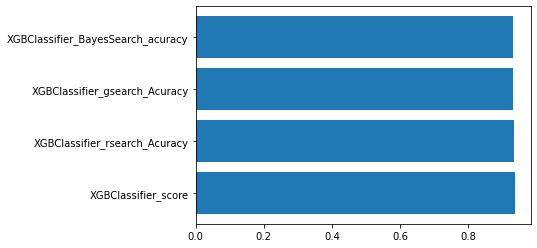

In [43]:
## Comparando os 4 modelos 
scores = pd.DataFrame([Model_XGBClassifier_score,XGBClassifier_rsearch_acuracy,
                       XGBClassifier_gsearch_acuracy,XGBClassifier_BayesSearch_acuracy])

scores['columns1'] =  ['XGBClassifier_score','XGBClassifier_rsearch_Acuracy',
                       'XGBClassifier_gsearch_Acuracy','XGBClassifier_BayesSearch_acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores']);

In [44]:
#Valor dos Scores dos modelos 
scores['Time(Seg)'] = time1,time2,time3,time4
xgb = scores
xgb

,Scores,Modelos,Time(Seg)
0,0.935987,XGBClassifier_score,1.745
1,0.935521,XGBClassifier_rsearch_Acuracy,62.811
2,0.932728,XGBClassifier_gsearch_Acuracy,54.007
3,0.932728,XGBClassifier_BayesSearch_acuracy,222.606


**Não há muita diferença no resultado do modelo em comparação ao GradientBoosting, porém o tempo de execução é menor**

# Comparar os modelos sem otimização:

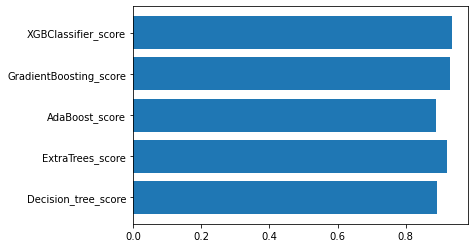

In [45]:
#Grafico dos Scores sem Otimização
import matplotlib.pyplot as plt
scores = pd.DataFrame([decision_tree_score,ExtraTrees_score,AdaBoost_score,
                       GradientBoosting_score,Model_XGBClassifier_score])

scores['Modelos'] =  ['Decision_tree_score','ExtraTrees_score','AdaBoost_score',
                      'GradientBoosting_score','XGBClassifier_score']

scores.columns = ['Scores','Modelos']
#Plotar 
plt.barh(scores.Modelos,scores['Scores']);

In [46]:
#Valor dos Scores dos modelos 
scores

,Scores,Modelos
0,0.891061,Decision_tree_score
1,0.920507,ExtraTrees_score
2,0.888734,AdaBoost_score
3,0.929818,GradientBoosting_score
4,0.935987,XGBClassifier_score


**Observamos que o modelo que obteve o melhor resultado foi: XGBClassifier, pois ele usa muitos parâmetros deixando o algoritmo mais robusto em relação aos outros**

# Comparar os modelos com Randomized Search

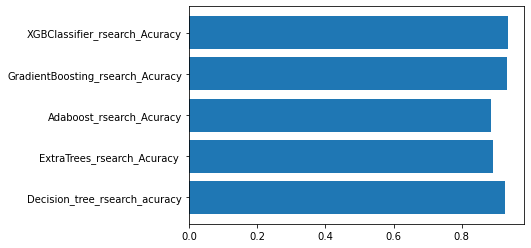

In [47]:
### Grafico dos Parametros com Randomized Search
import matplotlib.pyplot as plt

scores = pd.DataFrame([TreeClas_rsearch_acuracy,ExtraTrees_rsearch_acuracy ,
                       Adaboost_rsearch_acuracy,GradientBoosting_rsearch_acuracy,
                       XGBClassifier_rsearch_acuracy])

scores['Modelos'] =  ['Decision_tree_rsearch_acuracy','ExtraTrees_rsearch_Acuracy ',
                      'Adaboost_rsearch_Acuracy','GradientBoosting_rsearch_Acuracy',
                      'XGBClassifier_rsearch_Acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores']);

In [48]:
#Valor dos Scores dos modelos 
scores

,Scores,Modelos
0,0.927607,Decision_tree_rsearch_acuracy
1,0.891061,ExtraTrees_rsearch_Acuracy
2,0.886057,Adaboost_rsearch_Acuracy
3,0.933426,GradientBoosting_rsearch_Acuracy
4,0.935521,XGBClassifier_rsearch_Acuracy


**Os modelos que tiveram melhor resultado foram: GradientBoosting_rsearch e  XGBClassifier_rsearch**

# Comparar os modelos com Grid Search

<BarContainer object of 5 artists>

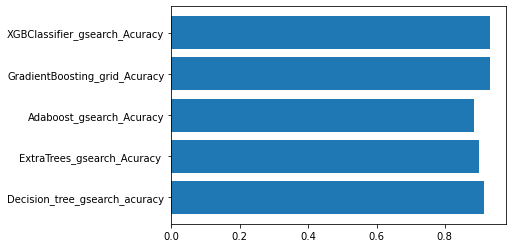

In [49]:
scores = pd.DataFrame([TreeClas_gsearch_acuracy,ExtraTrees_gsearch_acuracy ,
                       Adaboost_gsearch_acuracy,GradientBoosting_grid_acuracy,
                       XGBClassifier_gsearch_acuracy])

scores['Modelos'] =  ['Decision_tree_gsearch_acuracy','ExtraTrees_gsearch_Acuracy ',
                      'Adaboost_gsearch_Acuracy','GradientBoosting_grid_Acuracy',
                      'XGBClassifier_gsearch_Acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores'])

In [50]:
#Valor dos Scores dos modelos 
scores

,Scores,Modelos
0,0.914455,Decision_tree_gsearch_acuracy
1,0.899907,ExtraTrees_gsearch_Acuracy
2,0.886057,Adaboost_gsearch_Acuracy
3,0.932961,GradientBoosting_grid_Acuracy
4,0.932728,XGBClassifier_gsearch_Acuracy


**Os modelos que tiveram melhor resultado foram: GradientBoosting_grid_Acuracy e XGBClassifier_gsearch_Acuracy**

# Comparar os modelos com Bayesian Optimization

<BarContainer object of 5 artists>

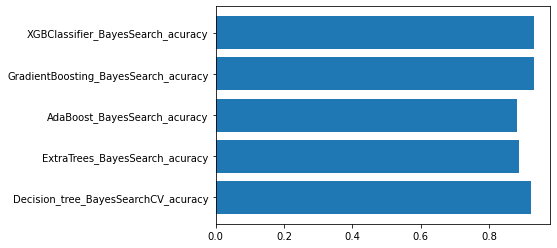

In [51]:
#Grafico dos Parametros com Bayesian Optimization

scores = pd.DataFrame([TreeClas_BayesSearchCV_acuracy,ExtraTrees_BayesSearch_acuracy,
                       AdaBoost_BayesSearch_acuracy,GradientBoosting_BayesSearch_acuracy,
                       XGBClassifier_BayesSearch_acuracy])

scores['Modelos'] =  ['Decision_tree_BayesSearchCV_acuracy','ExtraTrees_BayesSearch_acuracy',
                      'AdaBoost_BayesSearch_acuracy','GradientBoosting_BayesSearch_acuracy',
                      'XGBClassifier_BayesSearch_acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores'])

In [52]:
#Valor dos Scores dos modelos 
scores

,Scores,Modelos
0,0.922370,Decision_tree_BayesSearchCV_acuracy
1,0.887337,ExtraTrees_BayesSearch_acuracy
2,0.880819,AdaBoost_BayesSearch_acuracy
3,0.933194,GradientBoosting_BayesSearch_acuracy
4,0.932728,XGBClassifier_BayesSearch_acuracy


**Os modelos que tiveram melhor resultado foram: GradientBoosting_BayesSearch_acuracy e XGBClassifier_BayesSearch_acuracy**

# Comparação de Todos os Modelo:

In [61]:
# Modelos
modelo_completo = pd.concat([dts,ert,adb,gb,xgb])
modelo_completo = modelo_completo.set_index('Modelos')
modelo_completo.sort_values('Scores',ascending=False)

,Scores,Time(Seg)
Modelos,,
XGBClassifier_score,0.935987,1.745
XGBClassifier_rsearch_Acuracy,0.935521,62.811
GradientBoosting_rsearch_Acuracy,0.933426,51.898
GradientBoosting_BayesSearch_acuracy,0.933194,339.218
GradientBoosting_grid_Acuracy,0.932961,227.343
XGBClassifier_BayesSearch_acuracy,0.932728,222.606
XGBClassifier_gsearch_Acuracy,0.932728,54.007
GradientBoosting_score,0.929818,2.334
TreeClas_rsearch_acuracy,0.927607,19.719


**Notamos que nem sempre o melhor modelo requer o maior tempo de poder computacional, e o resultado depende muito do algoritmo usado e do seu otimizador. Os algoritmos com a melhor média foram: XGBClassifier e GradientBoosting**

# Conclusão:

**Conclusão_1: Os Melhores modelos do método ensamble foi com os algoritmos GradientBoosting e XGBClassifier**

**Conclusão_2: Os modelos ensamble tem vários parâmetros que podem ser otimizados ainda mais, conseguindo chegar a um melhor resultado**

**Conclusão_3: Os Algoritmos GridSearch e o BayesSearch têm um processo computacional exaustivo, dependendo do conjunto de dados pode demorar horas ou dias para concluir o processo**

**O algoritmo Randomized Search é uma alternativa quando temos grandes conjuntos de dados, pois ele não testa todos os hiperparâmetros que foram passados, ele faz iterações randomizadas e com isso o processo computacional fica menor com excelentes resultados**
